In [1]:
from libaries import *
from data_loading import findFiles,LoadDataSignals
from global_parameters import *
from peak_to_peak_detection import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *

In [2]:
import os
print(os.listdir())

['libaries.py', 'hanning_7tap.png', 'hanning_smoothing_passes.png', 'uniform_moving_average.png', 'main.ipynb', 'waveform_detection', 'crosstalk_spectrum.png', 'data_loading.py', '__pycache__', 'plotting_module', 'clipped_signal_ns.png', 'peak_to_peak_detection.py', 'global_parameters.py', 'main.py', 'Data_Denoising']


In [3]:
def normalize_min_max(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


#### Extract relevant files for processing


In [4]:
waveforms=["sin","square"]
periods= ["1","5","9"]

expected_waveform= waveforms[0]
expected_periods= periods[2]

In [5]:

"""unique_file_list= findFiles(expected_waveform,expected_periods,sample_number=1)
unique_file_list"""

'unique_file_list= findFiles(expected_waveform,expected_periods,sample_number=1)\nunique_file_list'

#### Data Loading

In [6]:
file="/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/000mg.mat"

In [ ]:
#raw,Concentration,actual_waveform,periods=LoadDataSignals(unique_file_list[2],time_axis_start=0,time_axis_end=16000)
raw,Concentration,actual_waveform,periods=LoadDataSignals(file,time_axis_start=0,time_axis_end=16000)

raw.shape


NameError: name 'unique_file_list' is not defined

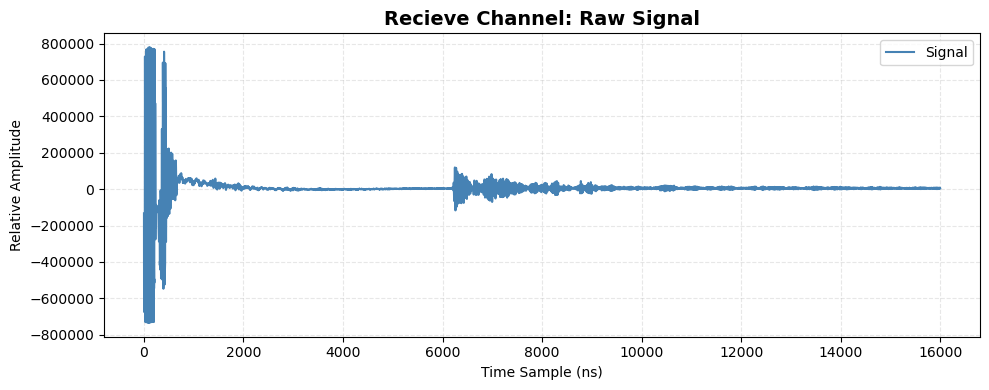

In [ ]:
signal_plot(raw[0,1,:],start=0,end=16000,title="Recieve Channel: Raw Signal")

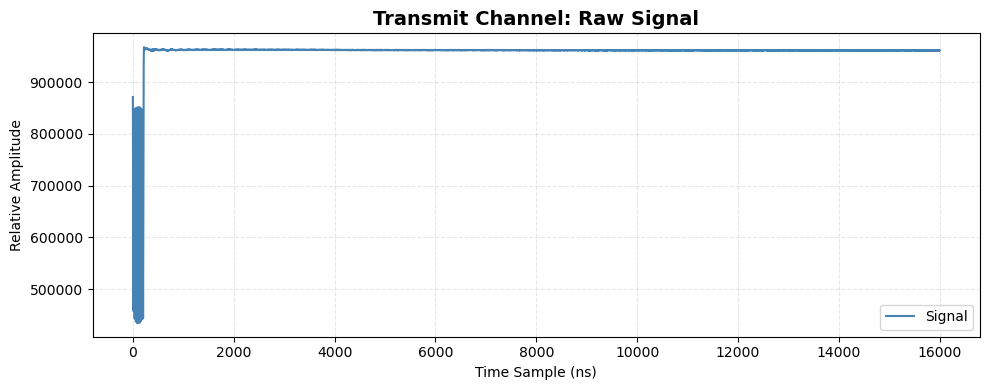

In [ ]:
signal_plot(raw[0,0,:],start=0,end=16000,title="Transmit Channel: Raw Signal")

## Data Processing

#### DC offset removal

In [ ]:
transmit, receive= dc_offset_removal(raw)

DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)


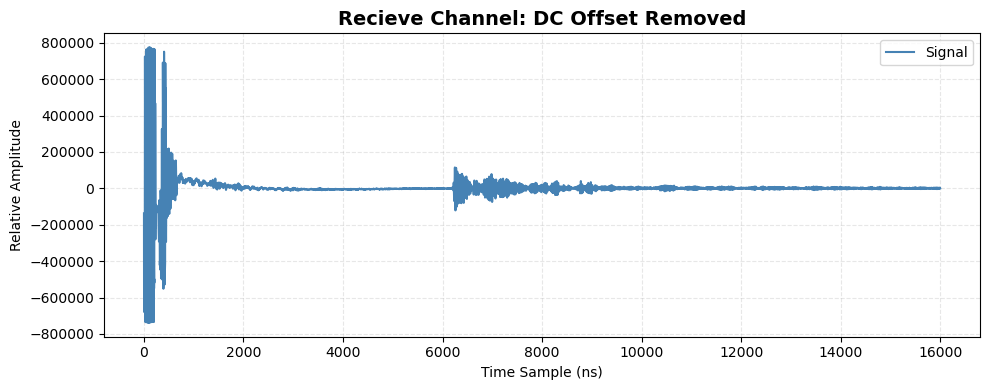

In [ ]:
signal_plot(receive[0,:],start=0,end=16000,title="Recieve Channel: DC Offset Removed")

# Different Filtering Techniques in Time Domain

#### Time Synchronized Averaging (Experiments=100)

In [ ]:
receive.shape

(100, 16000)

In [ ]:
transmit_averaged_signal,recieve_averaged_signal=time_synchronized_averaging(transmit,receive,threshold=500000)

Transmit Valid signals after filtering: (33, 16000)
Recieve Valid signals after filtering: (33, 16000)


In [ ]:
recieve_averaged_signal.shape

(1, 16000)

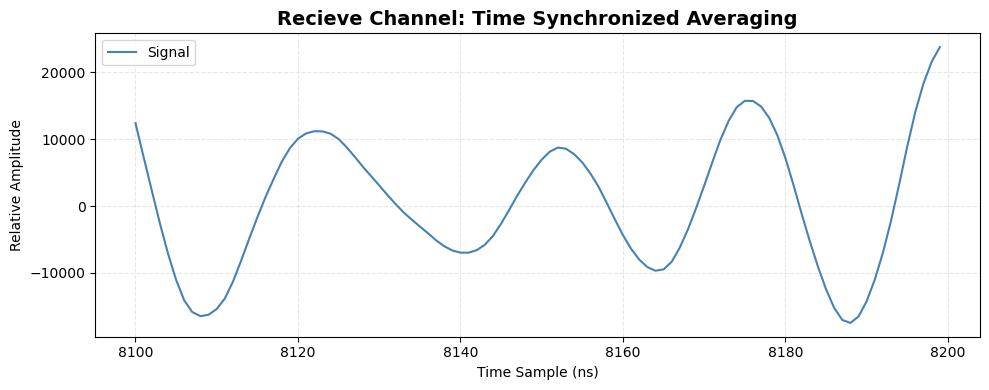

In [ ]:
signal_plot(recieve_averaged_signal[0],start=8100,end=8200,title="Recieve Channel: Time Synchronized Averaging")

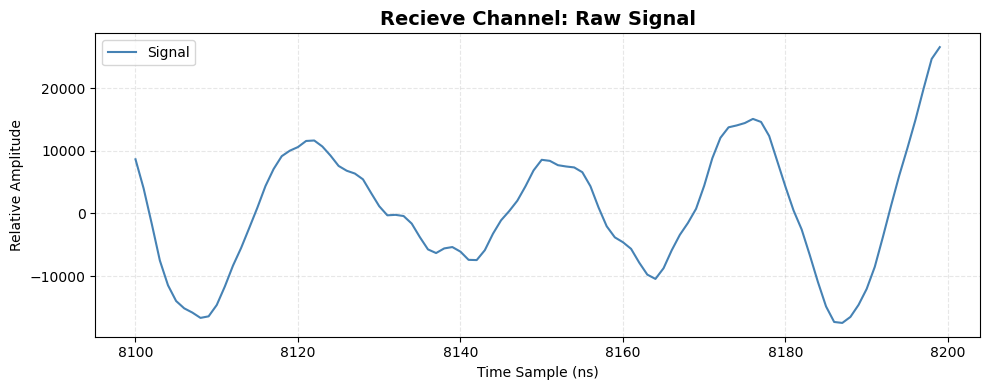

In [ ]:
signal_plot(receive[0,:],start=8100,end=8200,title="Recieve Channel: Raw Signal")

#### Moving Average : Hanning filter or Triangular Filter

In [ ]:
transmit_filtered_hanning = batch_apply_hanning_filter(transmit)
recieve_filtered_hanning = batch_apply_hanning_filter(receive)

In [ ]:
# Print shape to verify
print("Hanning filter Transmit shape:", transmit_filtered_hanning.shape) 
print("Hanning filter Recieve shape:", recieve_filtered_hanning.shape) 

Hanning filter Transmit shape: (100, 16000)
Hanning filter Recieve shape: (100, 16000)


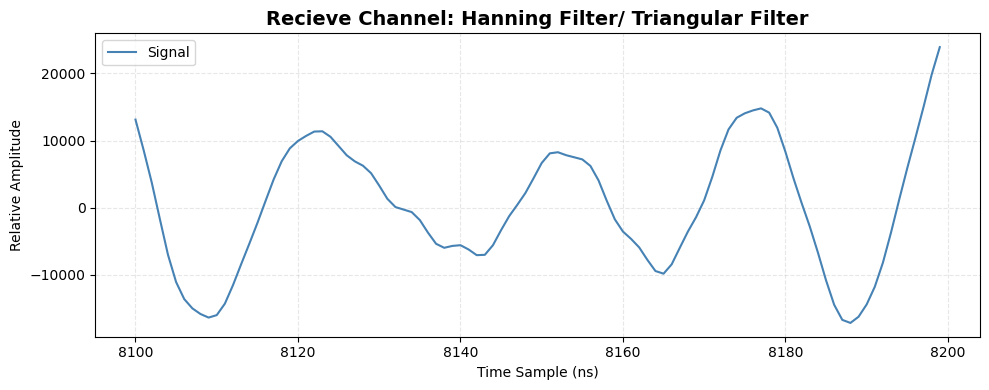

In [ ]:
signal_plot(recieve_filtered_hanning[0],start=8100,end=8200,title="Recieve Channel: Hanning Filter/ Triangular Filter")

#### Uniform Moving Average

In [ ]:
transmit_uniform_moving_avg=apply_uniform_moving_average_filter(transmit, window_size=11)
recieve_uniform_moving_avg=apply_uniform_moving_average_filter(receive, window_size=11)


In [ ]:
recieve_uniform_moving_avg.shape

(100, 16000)

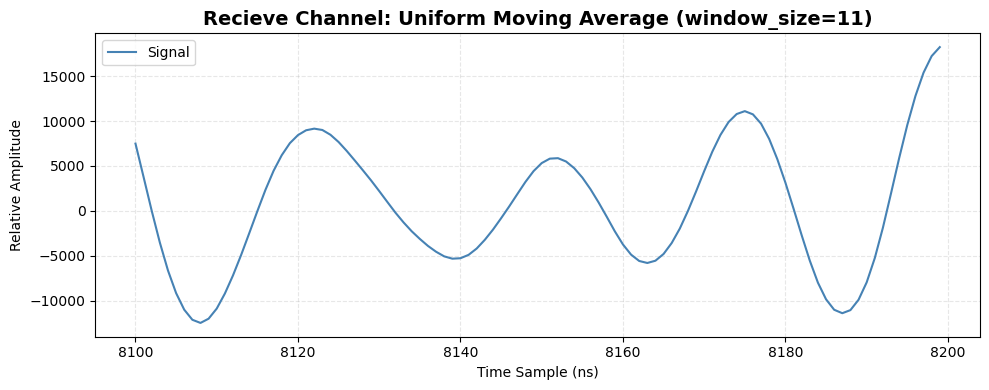

In [ ]:
signal_plot(recieve_uniform_moving_avg[0],start=8100,end=8200,title="Recieve Channel: Uniform Moving Average (window_size=11)")

#### Derivative Filter

In [ ]:
fs = 125e6  # Sampling frequency in Hz
T = 1 / fs  # Sampling period in seconds

In [ ]:
transmit_filtered_derivative=apply_improved_derivative_filter(transmit, T=T)
receive_filtered_derivative=apply_improved_derivative_filter(receive, T=T)


In [ ]:
receive_filtered_derivative.shape

(100, 16000)

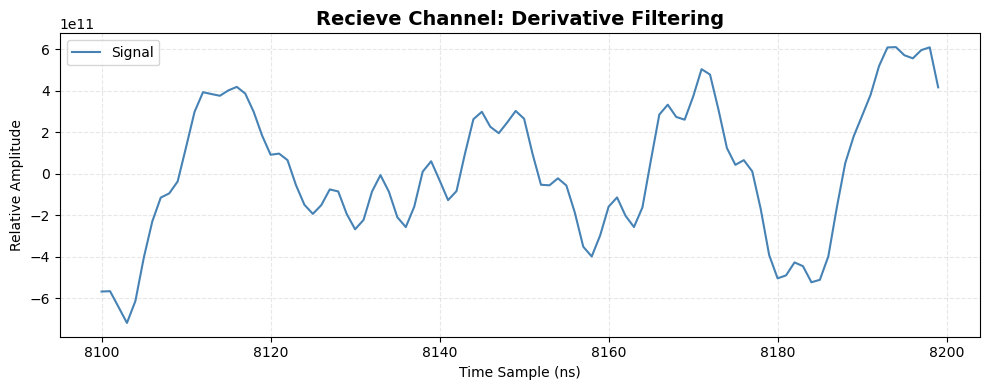

In [ ]:
signal_plot(receive_filtered_derivative[0,:],start=8100,end=8200,title="Recieve Channel: Derivative Filtering")

### For smoothning of derivative filter, a uniform average filter is being applied

In [ ]:
receive_filtered_derivative_smoothened=apply_uniform_moving_average_filter(receive_filtered_derivative, window_size=11)


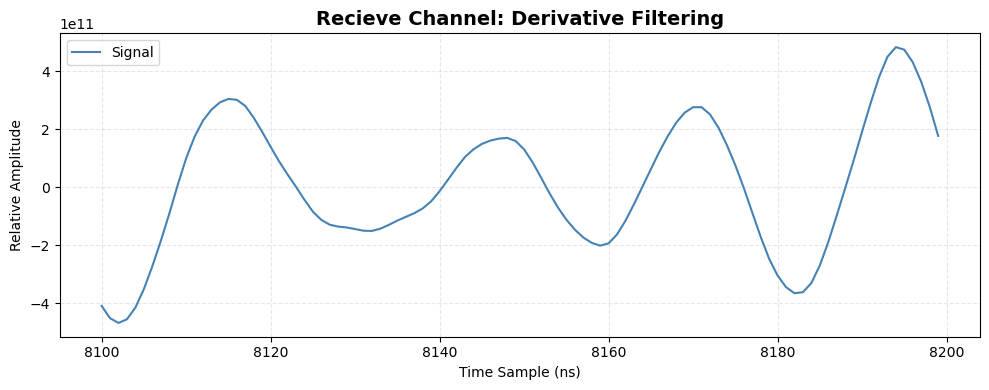

In [ ]:
signal_plot(receive_filtered_derivative_smoothened[0,:],start=8100,end=8200,title="Recieve Channel: Derivative Filtering")

#### High Pass Filter

In [ ]:

def highpass_filter(data, cutoff, fs, order=5):
    """
    Apply a high-pass Butterworth filter to a 2D signal array.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    # Design Butterworth high-pass filter
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    # Apply filter to each signal
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data


In [ ]:
cutoff = 1_000_000  # 1 MHz
order = 1

recieve_highpass_filtered = highpass_filter(receive, cutoff, fs, order)


In [ ]:
recieve_highpass_filtered.shape

(100, 16000)

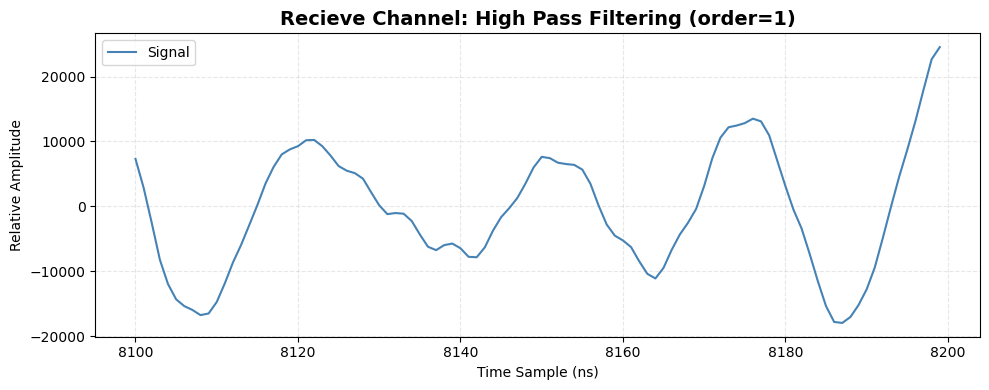

In [ ]:
signal_plot(recieve_highpass_filtered[0,:],start=8100,end=8200,title="Recieve Channel: High Pass Filtering (order=1)")

### Bandpass Filter

In [ ]:
start=0
end=16000

In [ ]:
bandpassed_receive = apply_bandpass_filter(receive[0, start:end], fs, 1e6, 6.5e6)
bandpassed_avg = apply_bandpass_filter(recieve_averaged_signal[0, start:end], fs, 4e6, 6e6)
bandpassed_hanning = apply_bandpass_filter(recieve_filtered_hanning[0, start:end], fs, 4e6, 6e6)


In [ ]:
bandpassed_receive.shape

(16000,)

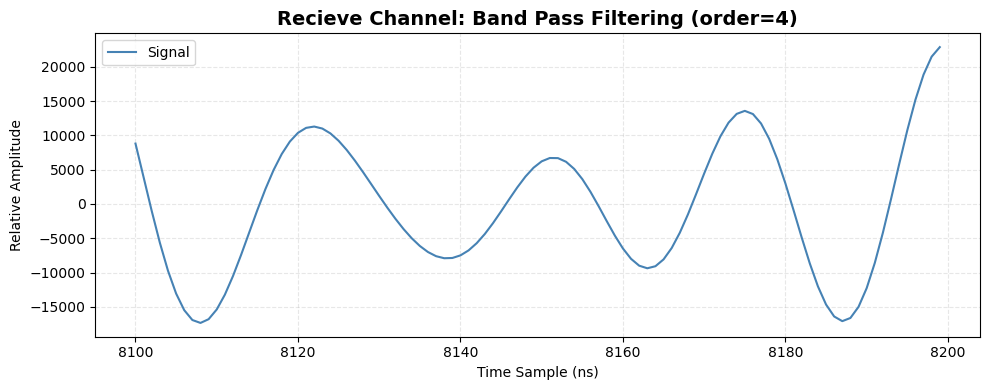

In [ ]:

signal_plot(bandpassed_receive[:],start=8100,end=8200,title="Recieve Channel: Band Pass Filtering (order=4)")

#### Data Plotting (For Testing)

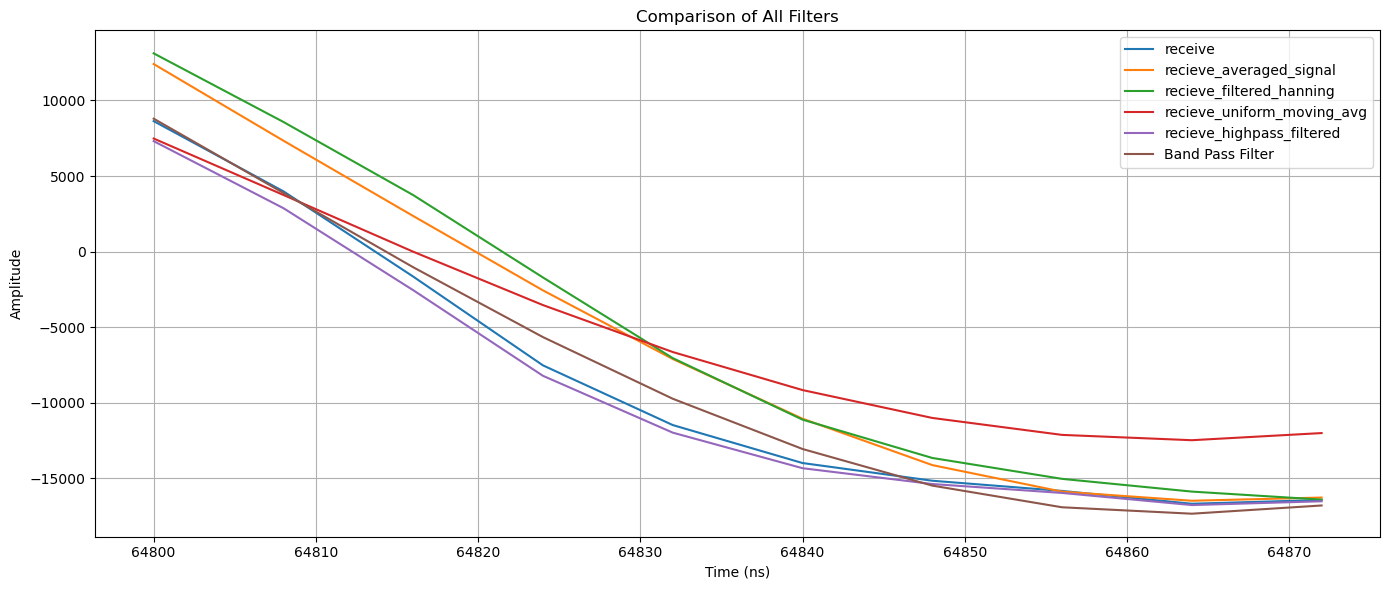

In [ ]:
start=0
end=16000
Ts_ns = 1e9 / fs  # Sampling period in nanoseconds
time = np.arange(start, end) * Ts_ns

# Time setup again
zoom_local_start = 8100 - start
zoom_local_end = 8110 - start
zoom_time = time[zoom_local_start:zoom_local_end]

# Scale derivative for fair visual comparison
scaled_derivative = receive_filtered_derivative_smoothened[0, zoom_local_start:zoom_local_end] / 1e12  # Trillions to hundreds

plt.figure(figsize=(14, 6))

plt.plot(zoom_time, receive[0, zoom_local_start + start : zoom_local_end + start], label='receive')
plt.plot(zoom_time, recieve_averaged_signal[0, zoom_local_start:zoom_local_end], label='recieve_averaged_signal')
plt.plot(zoom_time, recieve_filtered_hanning[0, zoom_local_start:zoom_local_end], label='recieve_filtered_hanning')
plt.plot(zoom_time, recieve_uniform_moving_avg[0, zoom_local_start:zoom_local_end], label='recieve_uniform_moving_avg')
plt.plot(zoom_time, recieve_highpass_filtered[0, zoom_local_start:zoom_local_end], label='recieve_highpass_filtered')
plt.plot(zoom_time, bandpassed_receive[zoom_local_start:zoom_local_end], label='Band Pass Filter')


plt.title("Comparison of All Filters")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Echo Detection

### Pan-Tompkins Inspired Pipeline / Pan–Tompkins algorithm


In [ ]:
bandpassed_receive.shape

(16000,)

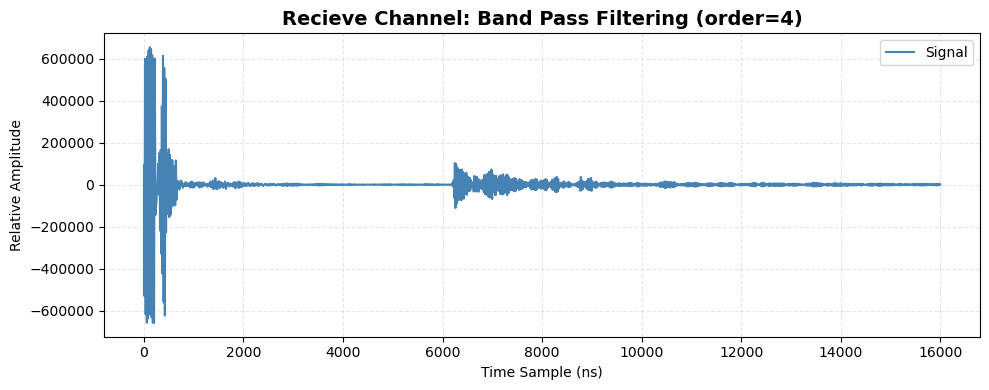

In [ ]:
signal_plot(bandpassed_receive[:],start=0,end=16000,title="Recieve Channel: Band Pass Filtering (order=4)")

In [ ]:
echo_derivative_filtered_data=apply_improved_derivative_filter(bandpassed_receive,T=T)

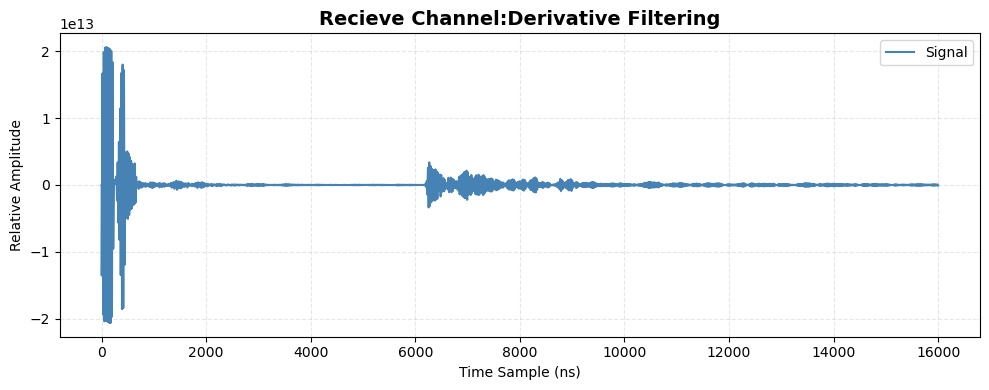

In [ ]:
signal_plot(echo_derivative_filtered_data[:],start=0,end=16000,title="Recieve Channel:Derivative Filtering")

In [ ]:
normalized_echo = normalize_min_max(echo_derivative_filtered_data)


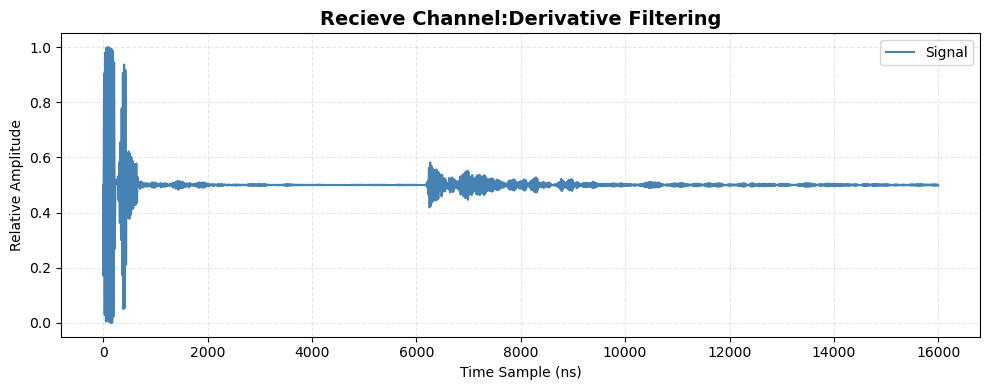

In [ ]:
signal_plot(normalized_echo[:],start=0,end=16000,title="Recieve Channel:Derivative Filtering")

In [ ]:
squared_output = normalized_echo ** 2


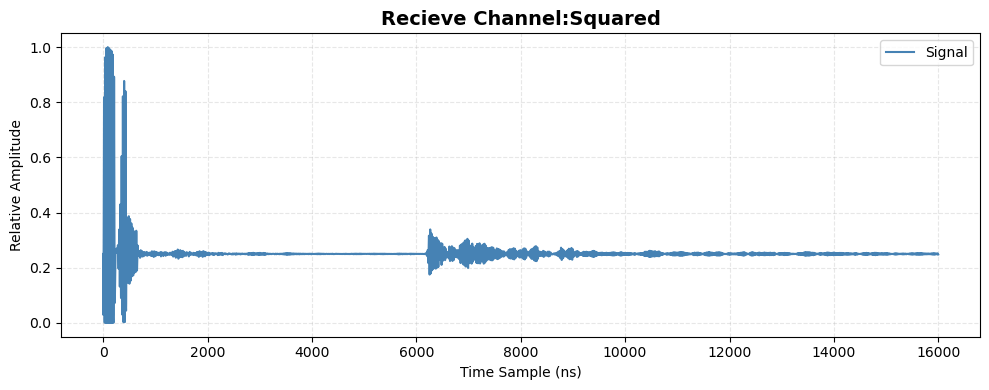

In [ ]:
signal_plot(squared_output[:],start=0,end=16000,title="Recieve Channel:Squared")

In [ ]:
normalized_squared_output = squared_output / np.max(np.abs(squared_output))


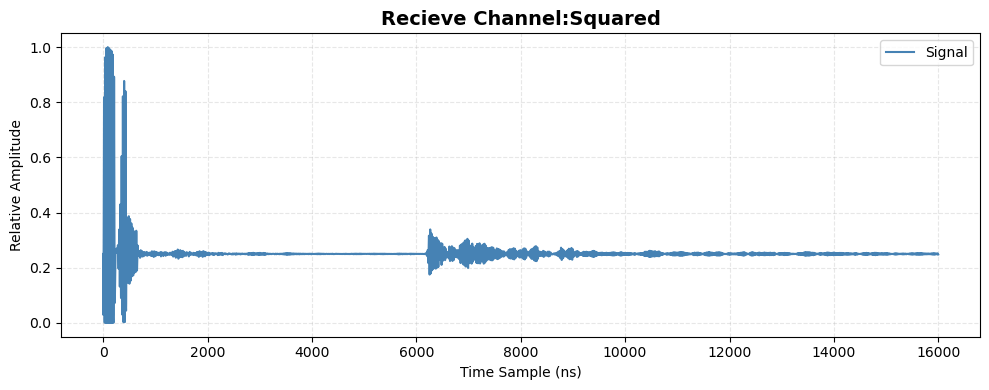

In [ ]:
signal_plot(normalized_squared_output[:],start=0,end=16000,title="Recieve Channel:Squared")

In [ ]:
normalized_squared_output.shape

(16000,)

In [ ]:
integrated_output = moving_average_integrator(normalized_squared_output, window_size=11)

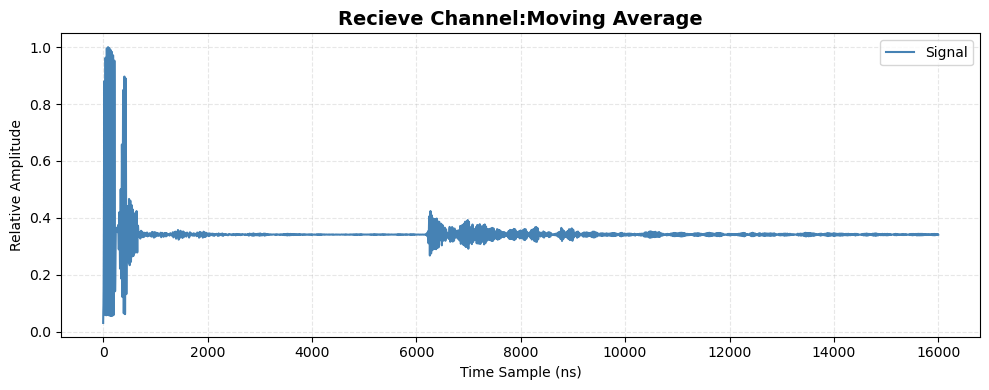

In [ ]:
signal_plot(integrated_output[:],start=0,end=16000,title="Recieve Channel:Moving Average")

# Algorithm Testing

In [ ]:
from waveform_detection.pan_algorithm import *

In [ ]:
low_cutoff=1e6
high_cutoff=5e6
periods=9

In [ ]:
receive.shape

bandpassed_receive = receive[0, start:end]
bandpassed_transmit = transmit[0, start:end]

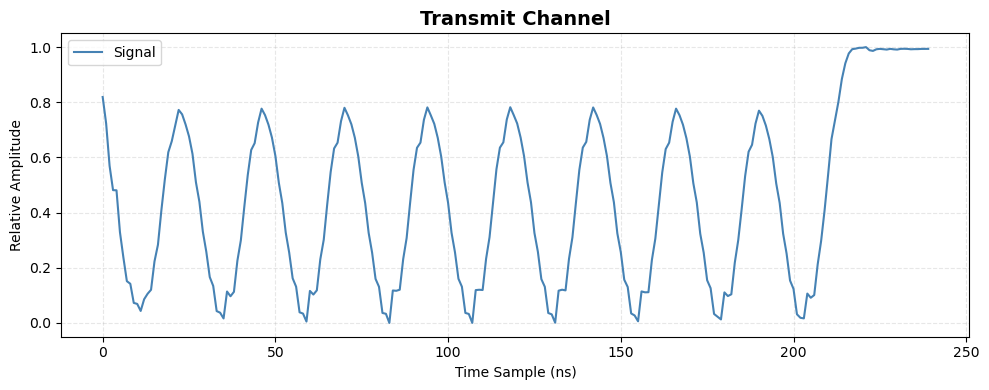

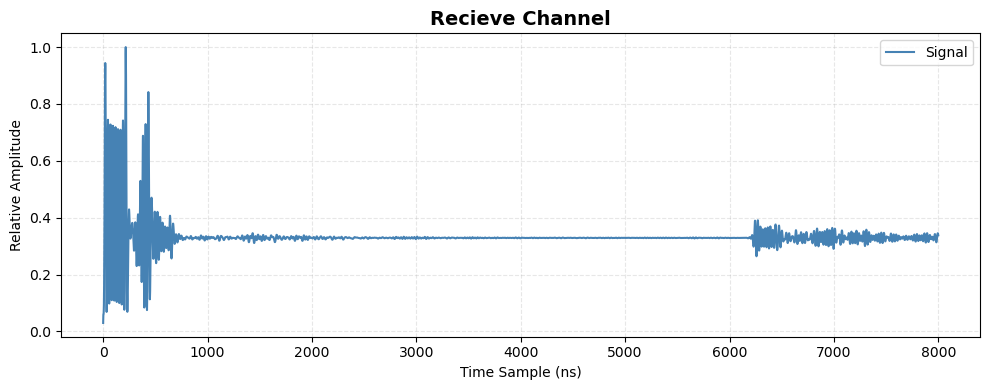

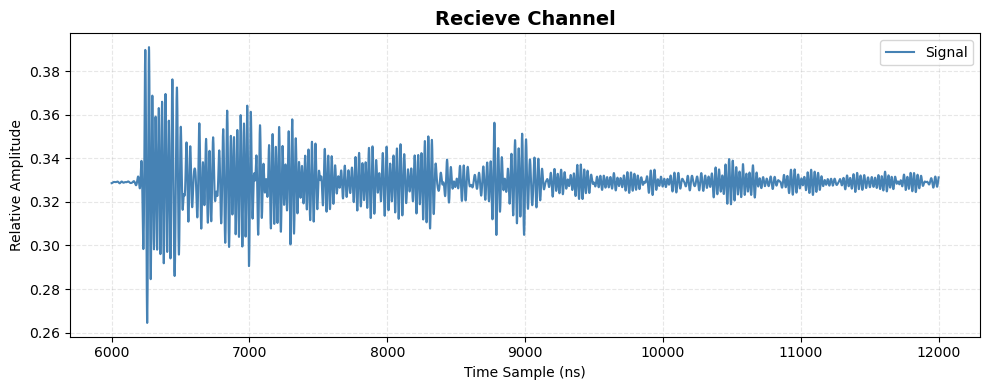

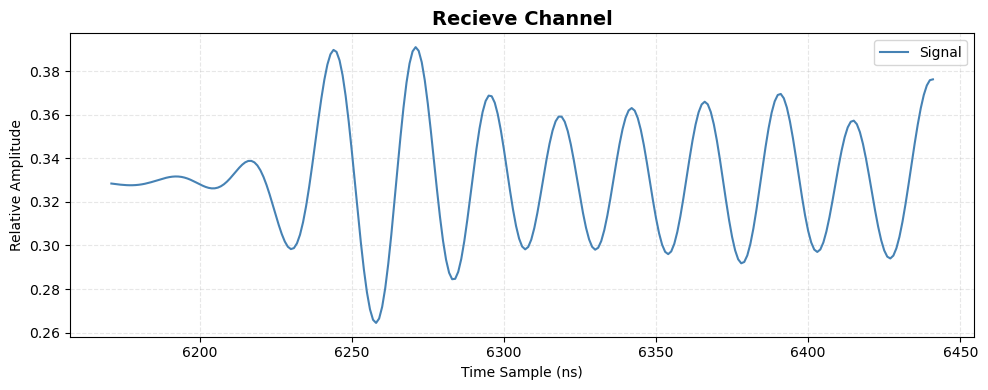

Dynamic Start Threshold: 0.5
Dynamic End Threshold: 0.2
Dynamic Start Threshold: 0.01
Dynamic End Threshold: 0.005
Transmit [(0, 221)]
Recieve [(2230, 4791)]


NameError: name 'recieve_min_max_pairs' is not defined

In [ ]:
apply_pan_algorithm(bandpassed_transmit,bandpassed_receive,periods,T,low_cutoff, high_cutoff, order=4, window_size=11,min_prominence=0.05)

In [ ]:
a =0
if a :
    print(a)
